In [397]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [428]:
# Load the dataset
data = pd.read_csv('dataset.csv')
print(len(data))

# Randomly subset 1/109 of the data
data = data.sample(frac=0.01, random_state=42)  # Set random_state for reproducibility
data = data.reset_index(drop=True)
print(len(data))

1114608
11146


In [429]:
print(data.head())

   launch_speed  launch_angle         target
0          82.9         -21.0  Groundoutable
1          70.3         -56.0  Groundoutable
2          82.9         -21.0  Groundoutable
3          97.4          21.0         Double
4          83.5           0.0  Groundoutable


In [430]:
# Convert the 'target' column to 1-hot encoded vectors
data_one_hot = pd.get_dummies(data, columns=['target'])

# Rename the columns to "prob_<category>"
data_one_hot = data_one_hot.rename(columns=lambda col: f"prob_{col.split('_')[-1]}" if 'target_' in col else col)

# Convert the 1-hot encoded columns to floats (0.0 and 1.0)
data_one_hot = data_one_hot.astype(float)

# Round 'launch_speed' and 'launch_angle' to integers
data_one_hot["launch_speed"] = data_one_hot["launch_speed"].round(0).astype(int)
data_one_hot["launch_angle"] = data_one_hot["launch_angle"].round(0).astype(int)

order = [
    "launch_speed", "launch_angle",
    "prob_Single", "prob_Double", "prob_Triple", "prob_Homerun",
    "prob_Groundoutable", "prob_Flyoutable", "prob_Lineoutable"
]

# Reorder the DataFrame
existing_columns = [col for col in order if col in data_one_hot.columns]
data_one_hot = data_one_hot[existing_columns]

print(data_one_hot.head())


   launch_speed  launch_angle  prob_Single  prob_Double  prob_Triple  \
0            83           -21          0.0          0.0          0.0   
1            70           -56          0.0          0.0          0.0   
2            83           -21          0.0          0.0          0.0   
3            97            21          0.0          1.0          0.0   
4            84             0          0.0          0.0          0.0   

   prob_Homerun  prob_Groundoutable  prob_Flyoutable  prob_Lineoutable  
0           0.0                 1.0              0.0               0.0  
1           0.0                 1.0              0.0               0.0  
2           0.0                 1.0              0.0               0.0  
3           0.0                 0.0              0.0               0.0  
4           0.0                 1.0              0.0               0.0  


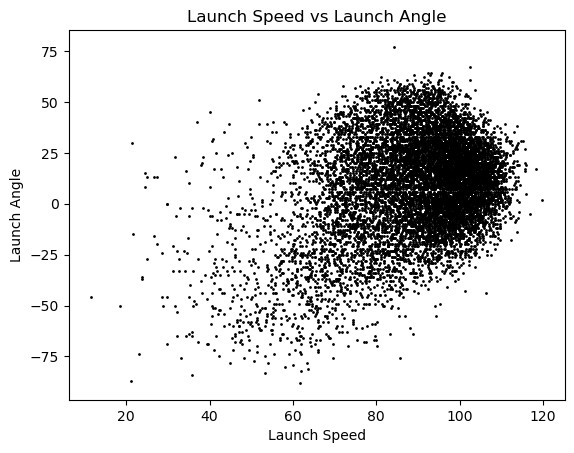

In [431]:
# Create a scatter plot
plt.scatter(data['launch_speed'], data['launch_angle'], color='black', s=1)
plt.title('Launch Speed vs Launch Angle')
plt.xlabel('Launch Speed')
plt.ylabel('Launch Angle')
plt.show()

In [432]:
# Print ranges for 'launch_speed' and 'launch_angle', and unique categories in 'target'
launch_speed_min, launch_speed_max = round(data['launch_speed'].min()), round(data['launch_speed'].max())
launch_angle_min, launch_angle_max = round(data['launch_angle'].min()), round(data['launch_angle'].max())
target_categories = data['target'].unique()

print(f"Launch Speed Min/Max: {launch_speed_min},{launch_speed_max}")
print(f"Launch Angle Min/Max: {launch_angle_min},{launch_angle_max}")
print(f"Target Categories: {target_categories}")

#### Notes
# We see that the values of Launch Angle are strictly integers

launch_speed_range = range(launch_speed_min, launch_speed_max, 1)  # Launch speed from 5 to 125, step 1
launch_angle_range = range(launch_angle_min, launch_angle_max, 1)  # Launch angle from -90 to 85, step 1

Launch Speed Min/Max: 12,120
Launch Angle Min/Max: -88,77
Target Categories: ['Groundoutable' 'Double' 'Single' 'Lineoutable' 'Flyoutable' 'Homerun'
 'Triple']


In [433]:
# 9/1/1 train/validation/test split
train_data, temp_data = train_test_split(data_one_hot, test_size=0.1, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Display the sizes of the splits
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# Optionally, you can save them back to CSV files:
# train_data.to_csv('train_data.csv', index=False)
# val_data.to_csv('val_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

# Extract features (X) and target (Y) for train, validation, and test sets
# For training set
X_train = train_data.drop(columns=train_data.filter(regex='^prob_').columns)  # Drop all columns starting with 'prob_'
Y_train = train_data.filter(regex='^prob_')  # Select all columns starting with 'prob_'
# For validation set
X_val = val_data.drop(columns=val_data.filter(regex='^prob_').columns)
Y_val = val_data.filter(regex='^prob_')
# For test set
X_test = test_data.drop(columns=test_data.filter(regex='^prob_').columns)
Y_test = test_data.filter(regex='^prob_')

# Display shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

Training set size: 10031
Validation set size: 557
Test set size: 558
X_train shape: (10031, 2), Y_train shape: (10031, 7)
X_val shape: (557, 2), Y_val shape: (557, 7)
X_test shape: (558, 2), Y_test shape: (558, 7)


In [434]:
# We will assume the following 8 classes:
ALL_CLASSES = [
    "prob_Single", "prob_Double", "prob_Triple", "prob_Homerun",
    "prob_Groundoutable", "prob_Flyoutable", "prob_Lineoutable"]

def PNN(query_point, train_data, k=3):
    """
    Given:
      query_point: (launch_speed, launch_angle)
      train_data:  Nx9 dataframe; First 2 columns are features, next 7 are 1-hot encoded classes.
      k:           Integer of neighbors to consider

    Return:
      A vector of probabilities; each element probability for class in ALL_Classes,
      with special handling:
        - If features is empty (N=0), returns all 0 probabilities and warns.
        - If N < k, uses N as k and warns.
    """
    N = len(train_data)
    if N == 0:
        warnings.warn("No data points available.", UserWarning)
        # Return 0.0 for all classes
        return None

    if N < k:
        print(f"Number of data points (N={N}) is less than k={k}. Using N={N} instead.")
        k = N

    # Convert train_data to features & labels
    features = train_data[['launch_speed', 'launch_angle']].values
    labels = train_data[["prob_Single", "prob_Double", "prob_Triple", "prob_Homerun",
                         "prob_Groundoutable", "prob_Flyoutable", "prob_Lineoutable"]].values

    # Convert query_point to an array for vectorized math
    query_arr = np.array(query_point)

    # 1. Compute Euclidean distances to all points in 'features'
    #    features has shape (N, 2), query_arr is shape (2,)
    diffs = features - query_arr  # shape (N, 2)
    squared_diffs = diffs ** 2    # shape (N, 2)
    dist_array = np.sqrt(np.sum(squared_diffs, axis=1))  # shape (N,)

    # 2. Sort by distance and pick the indices of the k nearest
    sorted_indices = np.argsort(dist_array)
    k_nearest_indices = sorted_indices[:k]

    # 3. Sum the class probabilities of the k nearest
    #    Since labels is a NumPy array, summing along axis=0 produces a sum for each class.
    sum_prob = np.sum(labels[k_nearest_indices, :], axis=0)

    # 4. Convert the counts to probabilities by dividing by k.
    probabilities = [float(sum_prob[i]) / k for i in range(len(ALL_CLASSES))]

    return probabilities

In [435]:
# Sample training dataset for different test cases
train_data_1 = pd.DataFrame(columns=['launch_speed', 'launch_angle'] + ALL_CLASSES)  # Empty DataFrame

train_data_2 = pd.DataFrame({
    'launch_speed': [85.0, 90.0],
    'launch_angle': [10.0, 15.0],
    "prob_Single": [1, 0], "prob_Double": [0, 1], "prob_Triple": [0, 0],
    "prob_Homerun": [0, 0], "prob_Groundoutable": [0, 0], "prob_Flyoutable": [0, 0], "prob_Lineoutable": [0, 0]
})

train_data_3 = pd.DataFrame({
    'launch_speed': [90.0, 90.0, 90.0],
    'launch_angle': [20.0, 20.0, 20.0],
    "prob_Single": [1, 1, 1], "prob_Double": [0, 0, 0], "prob_Triple": [0, 0, 0],
    "prob_Homerun": [0, 0, 0], "prob_Groundoutable": [0, 0, 0], "prob_Flyoutable": [0, 0, 0], "prob_Lineoutable": [0, 0, 0]
})

train_data_4 = pd.DataFrame({
    'launch_speed': [80.0, 95.0, 100.0],
    'launch_angle': [5.0, 25.0, 30.0],
    "prob_Single": [0, 0, 1], "prob_Double": [1, 0, 0], "prob_Triple": [0, 1, 0],
    "prob_Homerun": [0, 0, 0], "prob_Groundoutable": [0, 0, 0], "prob_Flyoutable": [0, 0, 0], "prob_Lineoutable": [0, 0, 0]
})

train_data_5 = pd.DataFrame({
    'launch_speed': [85.0] * 7,
    'launch_angle': [10.0] * 7,
    "prob_Single": [1, 0, 0, 0, 0, 0, 0], "prob_Double": [0, 1, 0, 0, 0, 0, 0],
    "prob_Triple": [0, 0, 1, 0, 0, 0, 0], "prob_Homerun": [0, 0, 0, 1, 0, 0, 0],
    "prob_Groundoutable": [0, 0, 0, 0, 1, 0, 0], "prob_Flyoutable": [0, 0, 0, 0, 0, 1, 0],
    "prob_Lineoutable": [0, 0, 0, 0, 0, 0, 1]
})

# Query points
query_1 = (85.0, 10.0)  # Identical to some points
query_2 = (200.0, 90.0)  # Far from all
query_3 = (90.0, 20.0)  # Exactly in training data
query_4 = (92.0, 18.0)  # Between multiple clusters

# Running tests
test_cases = [
    (train_data_1, query_1, 3, "Empty training data"),
    (train_data_2, query_1, 5, "k larger than available"),
    (train_data_3, query_3, 3, "All training points identical"),
    (train_data_4, query_4, 2, "Cluster vs Outlier"),
    (train_data_5, query_1, 3, "All classes equally represented"),
]

# Execute tests
for i, (train_data, query, k, description) in enumerate(test_cases):
    print(f"\nTest {i+1}: {description}")
    try:
        probabilities = PNN(query, train_data, k)
        print("Probabilities:", probabilities)
    except Exception as e:
        print("Error:", str(e))



Test 1: Empty training data
Probabilities: None

Test 2: k larger than available
Number of data points (N=2) is less than k=5. Using N=2 instead.
Probabilities: [0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]

Test 3: All training points identical
Probabilities: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Test 4: Cluster vs Outlier
Probabilities: [0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0]

Test 5: All classes equally represented
Probabilities: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0]


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


In [436]:
def train_PNN(X_train, Y_train, k, launch_speed_range, launch_angle_range):
    """
    Trains probabilistic nearest neighbor algorithm.
    It gradually “pseudolabels” candidate points (from all (launch_speed, launch_angle)
    combinations) by finding their nearest neighbor in train_data and then, for points
    that are equally far (by L1 distance) from a neighbor, calling probabilisticKNN on a trimmed subset.
    
    This version is written so that it can be extended to more than 2 variables (but currently
    it uses exactly 'launch_speed' and 'launch_angle'). You can generalize the trimming and nearest
    neighbor search to higher dimensions by adjusting the code.
    
    Inputs:
        train_data: DataFrame with columns:
                    - 'launch_speed', 'launch_angle'
                    - plus probability columns.
        k: number of nearest neighbors to use.
        launch_speed_range: an iterable of possible launch_speed values.
        launch_angle_range: an iterable of possible launch_angle values.
        
    Returns:
        final: list of pseudolabeled dictionaries (each containing theQcandidate point and its probability vector).
    """
    # Combine X_train and Y_train—it's less complex this way.
    train_data = pd.concat([X_train, Y_train], axis=1)

    print("Setting up...")
    # Sort train_data based on launch_speed then launch_angle 
    train_data = train_data.sort_values(['launch_speed','launch_angle']).reset_index(drop=True)

    # enough_dist: list of all (launch_speed, launch_angle) combinations
    enough_dist = pd.DataFrame(itertools.product(launch_speed_range, launch_angle_range), columns=['launch_speed', 'launch_angle'])
    enough_dist['norm'] = None 

    dist = -1
    final_points = []  # To accumulate all pseudolabeled points
    batch_points = []  # To accumulate the current batch of points

    print("Done setting up.")
    while not enough_dist.empty:
    #   For each (launch_speed, launch_angle) in enough_dist:  
	#       Find approximate closest proximity (L1-norm) in train_data  
	# 	        (Find closest launch_speed then closest launch_angle in train_data)
        for index, row in enough_dist.iterrows():
            candidate_speed = row["launch_speed"]
            candidate_angle = row["launch_angle"]
            # Compute the L1 distances between the candidate and each point in train_data.
            # L1 distance = |launch_speed difference| + |launch_angle difference|
            distances = abs(train_data["launch_speed"] - candidate_speed) + abs(train_data["launch_angle"] - candidate_angle)
            min_dist = distances.min()
            enough_dist.at[index, "norm"] = int(min_dist)

        print("Finished calculating approx_closest proximity.")
    #   Sort enough_dist by L1-norm	
        enough_dist.sort_values(by="norm", inplace=True)
        # print("Enough_dist tail:")
        # print(enough_dist.tail(5))
        enough_dist.reset_index(drop=True, inplace=True)

        if not enough_dist.empty: 
            last_idx = enough_dist.index[-1]
            next_up = enough_dist.loc[last_idx]
            enough_dist.drop(index=last_idx, inplace=True)
        else:
            break

        if dist == -1:
            dist = next_up['norm'] 			
    #   While dist == next_up[norm] and dist >= 1:
    #       Trim train_data to within ±½√max(n,m) of next_up[launch_speed, launch_angle]
    #       res = PNN(launch_speed,launch_angle,train_data,𝓀)	
    #       Add res to final, batch
        Counta=0
        print(f"Running PNN algorithm for dist = {dist}")
        while dist == next_up['norm'] and dist >= 0:
            Counta+=1
            # Trim within ±½√max(n,m)
            within = round(0.5 * np.sqrt(max(max(launch_speed_range), max(launch_angle_range))),1)
            # We can slice for launch_speed which train_data is first sorted by
            speed_lower, speed_upper = next_up["launch_speed"]-within, next_up["launch_speed"]+within
            left_idx = train_data['launch_speed'].searchsorted(speed_lower, side='left')
            right_idx = train_data['launch_speed'].searchsorted(speed_upper, side='right')
            speed_subset = train_data.iloc[left_idx:right_idx]
            # Further filter the subset by launch_angle.
            trimmed_td = speed_subset[np.abs(speed_subset['launch_angle'] - next_up["launch_angle"]) <= within]
            # Probabilistic NN
            try:
                res = PNN((next_up['launch_speed'], next_up['launch_angle']), trimmed_td, k)   
                if res is not None and len(res) == 7:
                    # PNN returns a vector of probabilities
                    pseudolabeled_point = pd.DataFrame([{ 
                        'launch_speed': next_up["launch_speed"], 
                        'launch_angle': next_up["launch_angle"], 
                        'prob_Single': res[0],
                        'prob_Double': res[1],
                        'prob_Triple': res[2],
                        'prob_Homerun': res[3],
                        'prob_Groundoutable': res[4],
                        'prob_Flyoutable': res[5],
                        'prob_Lineoutable': res[6]
                    }])
                    # Append only if the result is valid
                    final_points.append(pseudolabeled_point)
                    batch_points.append(pseudolabeled_point)
            except Warning as w:
                print(f"{w}")
            if enough_dist.empty:
                break  # Nothing to process; exit the loop.
            next_up = enough_dist.iloc[-1]   # Pop last element
            last_idx = enough_dist.index[-1]
            enough_dist.drop(index=last_idx, inplace=True)  # Remove that row from enough_dist
        print(f"Count on this dist: {Counta}")

        if next_up is not None:
            next_up_df = pd.DataFrame([next_up])  # Since last next_up["norm"] != dist, put it back in
            enough_dist = pd.concat([next_up_df, enough_dist], ignore_index=True)
    #   if batch not empty:
    # 	    Add results from this dist group to train_data as pseudolabels
    # 	    Clear this dist group batch
    # 	    Sort train_data based on launch_speed then launch_angle
        print(f"Remaining: {enough_dist.shape[0]}")
        if enough_dist.shape[0] == 1:
            break
        print(enough_dist.tail(5))
        if batch_points:
            batch_df = pd.concat(batch_points, ignore_index=True)
            try:
                final = pd.concat([final, batch_df], ignore_index=True)
            except NameError:
                final = batch_df.copy()
            train_data = pd.concat([train_data, batch_df], ignore_index=True)
            # If there was nothing in batch, there's no need to re-sort
            train_data = train_data.sort_values(['launch_speed','launch_angle'])
            train_data.reset_index(drop=True, inplace=True)    
        dist-=1 # Minimum increment across n,m

    final = pd.concat(final_points, ignore_index=True)
    # Sort final based on launch_speed then launch_angle
    final = final.sort_values(['launch_speed','launch_angle'])
    final.reset_index(drop=True, inplace=True)
    return final

In [437]:
start_time = time.time()
final_result = train_PNN(X_train, Y_train, 100, launch_speed_range, launch_angle_range)
prob_columns = [col for col in final_result.columns if col.startswith('prob_')]
final_result[prob_columns] = final_result[prob_columns].round(4)
random_sample = final_result.sample(n=100, random_state=42).reset_index(drop=True)
runtime = time.time() - start_time
print("\nRuntime for KNN predictions on grid: {:.6f} seconds".format(runtime))

# Print the sampled rows
print(random_sample)

Setting up...
Done setting up.
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 55
Count on this dist: 1
Remaining: 17819
       launch_speed  launch_angle norm
17814            13            74   52
17815            12            74   53
17816            13            75   53
17817            14            76   53
17818            12            75   54


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 54
Count on this dist: 2
Remaining: 17817
       launch_speed  launch_angle norm
17812            15            76   52
17813            12            73   52
17814            13            74   52
17815            14            76   53
17816            12            74   53


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 53
Count on this dist: 3
Remaining: 17814
       launch_speed  launch_angle norm
17809            13            73   51
17810            14            74   51
17811            13            74   52
17812            15            76   52
17813            14            75   52


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 52
Count on this dist: 4
Remaining: 17810
       launch_speed  launch_angle norm
17805            15            74   50
17806            13            73   51
17807            12            72   51
17808            16            76   51
17809            15            75   51


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 51
Count on this dist: 5
Remaining: 17805
       launch_speed  launch_angle norm
17800            17            76   50
17801            16            75   50
17802            13            72   50
17803            12            71   50
17804            14            73   50


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 50
Count on this dist: 6
Remaining: 17799
       launch_speed  launch_angle norm
17794            14            72   49
17795            15            73   49
17796            17            75   49
17797            16            74   49
17798            18            76   49


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 49
Count on this dist: 7
Remaining: 17792
       launch_speed  launch_angle norm
17787            16            73   48
17788            23            76   48
17789            12            69   48
17790            14            71   48
17791            18            75   48


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 48
Count on this dist: 9
Remaining: 17783
       launch_speed  launch_angle norm
17778            24            76   47
17779            14            70   47
17780            20            76   47
17781            17            73   47
17782            15            71   47


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 47
Count on this dist: 12
Remaining: 17771
       launch_speed  launch_angle norm
17766            12            67   46
17767            13            68   46
17768            20            75   46
17769            18            73   46
17770            21            76   46


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 46
Count on this dist: 14
Remaining: 17757
       launch_speed  launch_angle norm
17752            16            70   45
17753           119           -88   45
17754            25            75   45
17755            13            67   45
17756            19            73   45


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 45
Count on this dist: 16
Remaining: 17741
       launch_speed  launch_angle norm
17736            25            74   44
17737            18            71   44
17738            22            73   44
17739            17            70   44
17740            15            68   44


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 44
Count on this dist: 18
Remaining: 17723
       launch_speed  launch_angle norm
17718           117           -88   43
17719            21            73   43
17720            26            74   43
17721            20            72   43
17722            17            69   43


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 43
Count on this dist: 20
Remaining: 17703
       launch_speed  launch_angle norm
17698            22            71   42
17699            24            71   42
17700           116           -88   42
17701            18            69   42
17702            12            63   42


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 42
Count on this dist: 22
Remaining: 17681
       launch_speed  launch_angle norm
17676            15            65   41
17677            17            67   41
17678            12            62   41
17679            20            70   41
17680            29            75   41


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 41
Count on this dist: 24
Remaining: 17657
       launch_speed  launch_angle norm
17652            18            67   40
17653            13            62   40
17654           117           -85   40
17655           115           -87   40
17656            16            65   40


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 40
Count on this dist: 26
Remaining: 17631
       launch_speed  launch_angle norm
17626            18            66   39
17627            21            69   39
17628            13            61   39
17629           118           -83   39
17630           113           -88   39


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 39
Count on this dist: 28
Remaining: 17603
       launch_speed  launch_angle norm
17598            29            72   38
17599           117           -83   38
17600           119           -81   38
17601            17            64   38
17602            31            74   38


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 38
Count on this dist: 30
Remaining: 17573
       launch_speed  launch_angle norm
17568            27            69   37
17569           111           -88   37
17570            29            71   37
17571            24            66   37
17572           117           -82   37


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 37
Count on this dist: 34
Remaining: 17539
       launch_speed  launch_angle norm
17534            30            71   36
17535            20            65   36
17536            14            59   36
17537            18            63   36
17538           118           -71   36


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 36
Count on this dist: 38
Remaining: 17501
       launch_speed  launch_angle norm
17496            32            72   35
17497            18            62   35
17498            12            56   35
17499           119           -69   35
17500            19            63   35


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 35
Count on this dist: 42
Remaining: 17459
       launch_speed  launch_angle norm
17454            27            66   34
17455            33            72   34
17456           119           -68   34
17457           116           -80   34
17458            36            75   34


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 34
Count on this dist: 47
Remaining: 17412
       launch_speed  launch_angle norm
17407           115           -80   33
17408           116           -70   33
17409           118           -77   33
17410            17            59   33
17411           118           -68   33


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 33
Count on this dist: 52
Remaining: 17360
       launch_speed  launch_angle norm
17355           116           -74   32
17356            29            66   32
17357           116           -78   32
17358            14            55   32
17359            30            67   32


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 32
Count on this dist: 56
Remaining: 17304
       launch_speed  launch_angle norm
17299            19            59   31
17300            40            76   31
17301           116           -75   31
17302           117           -67   31
17303            25            61   31


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 31
Count on this dist: 61
Remaining: 17243
       launch_speed  launch_angle norm
17238            47            76   30
17239            14            53   30
17240           118           -63   30
17241            40            75   30
17242            30            65   30


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 30
Count on this dist: 64
Remaining: 17179
       launch_speed  launch_angle norm
17174            24            58   29
17175           112           -73   29
17176           119           -60   29
17177            28            62   29
17178            27            61   29


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 29
Count on this dist: 68
Remaining: 17111
       launch_speed  launch_angle norm
17106            24            57   28
17107            36            69   28
17108           113           -75   28
17109            40            73   28
17110            12            49   28


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 28
Count on this dist: 74
Remaining: 17037
       launch_speed  launch_angle norm
17032           110           -79   27
17033            12            48   27
17034            21            57   27
17035            44            70   27
17036           111           -74   27


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 27


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 78
Remaining: 16959
       launch_speed  launch_angle norm
16954            53            76   26
16955           111           -68   26
16956           103           -85   26
16957            54            75   26
16958           108           -71   26
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 26
Count on this dist: 83


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Remaining: 16876
       launch_speed  launch_angle norm
16871           113           -63   25
16872            22            54   25
16873           109           -78   25
16874            28            58   25
16875            34            64   25
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 25
Count on this dist: 87
Remaining: 16789
       launch_speed  launch_angle norm
16784            58            70   24
16785           105           -81   24
16786            60            72   24
16787            52            75   24
16788           104           -82   24


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 24
Count on this dist: 90
Remaining: 16699
       launch_speed  launch_angle norm
16694            27            55   23
16695            43            65   23
16696            55            71   23
16697           112           -61   23
16698           105           -80   23


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 23


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 93
Remaining: 16606
       launch_speed  launch_angle norm
16601           103           -81   22
16602           105           -73   22
16603            20            51   22
16604            28            55   22
16605            44            65   22
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 22


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 96
Remaining: 16510
       launch_speed  launch_angle norm
16505            22            50   21
16506           103           -71   21
16507            98           -85   21
16508           117            73   21
16509            31            57   21
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 21


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 101
Remaining: 16409
       launch_speed  launch_angle norm
16404            15            44   20
16405            14            43   20
16406            31            56   20
16407            60            68   20
16408            46            65   20
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 20


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 110
Remaining: 16299
       launch_speed  launch_angle norm
16294            44            62   19
16295            24            48   19
16296           100           -81   19
16297            60            67   19
16298           104           -77   19
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 19


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 125
Remaining: 16174
       launch_speed  launch_angle norm
16169            14            -5   18
16170            32            55   18
16171           118            63   18
16172            13            -1   18
16173            24            47   18
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 18


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 145
Remaining: 16029
       launch_speed  launch_angle norm
16024            80           -87   17
16025           114            72   17
16026            55            65   17
16027            60            65   17
16028            28            50   17
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 17


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 169
Remaining: 15860
       launch_speed  launch_angle norm
15855            38            59   16
15856            15           -66   16
15857            16            -2   16
15858            65            69   16
15859            80           -86   16
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 16


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 192
Remaining: 15668
       launch_speed  launch_angle norm
15663            82           -87   15
15664            70            76   15
15665           107           -58   15
15666           108           -57   15
15667            16            -6   15
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 15


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 219
Remaining: 15449
       launch_speed  launch_angle norm
15444            63            65   14
15445            15           -61   14
15446           115           -39   14
15447            71            71   14
15448           119           -28   14
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 14


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 251
Remaining: 15198
       launch_speed  launch_angle norm
15193           106           -57   13
15194            57            59   13
15195           117            56   13
15196            76           -83   13
15197            16            22   13
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 13


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 280
Remaining: 14918
       launch_speed  launch_angle norm
14913           116            56   12
14914           115            55   12
14915            12           -13   12
14916            98           -76   12
14917           105            76   12
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 12


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 307
Remaining: 14611
       launch_speed  launch_angle norm
14606            12            32   11
14607           118           -24   11
14608           114           -47   11
14609            93           -72   11
14610            17           -24   11
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 11


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 332
Remaining: 14279
       launch_speed  launch_angle norm
14274            14             8   10
14275           103           -51   10
14276            90            73   10
14277            52            61   10
14278            21           -66   10
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 10
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Count on this dist: 364
Remaining: 13915
       launch_speed  launch_angle norm
13910            74            65    9
13911            30            38    9
13912            19           -58    9
13913            70           -85    9
13914           103           -55    9
Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 9
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No da

Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Count on this dist: 107
Remaining: 13808
       launch_speed  launch_angle norm
13803            26            27    8
13804            87            72    8
13805            78           -76    8
13806            15           -74    8
13807            45            48    8


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 8
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=4) is less than k=100. Using N=4 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Count on this dist: 20
Remaining: 13788
       launch_speed  l

C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)
C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Finished calculating approx_closest proximity.
Running PNN algorithm for dist = 7
Number of data points (N=5) is less than k=100. Using N=5 instead.
Number of data points (N=5) is less than k=100. Using N=5 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=4) is less than k=100. Using N=4 instead.
Number of data points (N=6) is less than k=100. Using N=6 instead.
Number of data points (N=5) is less than k=100. Using N=5 instead.
Number of data points (N=6) is less than k=100. Using N=6 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.


C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Number of data points (N=5) is less than k=100. Using N=5 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=6) is less than k=100. Using N=6 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=5) is less than k=100. Using N=5 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=5) is less than k=100. Using N=5 inst

C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=6) is less than k=100. Using N=6 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=5) is less than k=100. Using N=5 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=4) is less than k=100. Using N=4 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=5) is less than k=100. Using N=5 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=4) is less than k=100. Using N=4 inst

C:\Users\mla21\AppData\Local\Temp\ipykernel_8616\253915210.py:21: UserWarning: No data points available. Returning all probabilities = 0.
  warnings.warn("No data points available. Returning all probabilities = 0.", UserWarning)


Number of data points (N=6) is less than k=100. Using N=6 instead.
Number of data points (N=5) is less than k=100. Using N=5 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=1) is less than k=100. Using N=1 instead.
Number of data points (N=10) is less than k=100. Using N=10 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=3) is less than k=100. Using N=3 instead.
Number of data points (N=2) is less than k=100. Using N=2 instead.
Number of data points (N=6) is less than k=100. Using N=6 instead.
Number of data points (N=4) is less than k=100. Using N=4 instead.
Number of data points (N=6) is less than k=100. Using N=6 instead.
Count on this dist: 107
Remaining: 13681
       launch_speed  launch_angle norm
13676            77            76    6
13677           119            24    6
13678            38           -77   

In [440]:

# print(final_result.head(100))

test_data = pd.concat([X_test, Y_test], axis=1)
test_data.rename(columns=lambda col: col.replace("prob_", "real_") if col.startswith("prob_") else col, inplace=True)
# Left join
print("Merged:")
merged_df = test_data.merge(final_result, on=['launch_speed', 'launch_angle'], how='left')
print(merged_df.head(5))

loss = 0.0
# Iterate through each row
for index, row in merged_df.iterrows():
    # Find columns that start with 'real_'
    real_columns = [col for col in merged_df.columns if col.startswith("real_")]

    # If no real_ columns exist, skip this row
    if not real_columns:
        continue

    # Find the real_ column with the highest value
    highest_real_column = max(real_columns, key=lambda col: row[col])

    # Find the corresponding prob_ column
    corresponding_prob_column = highest_real_column.replace("real_", "prob_")

    # Ensure the prob_ column exists before accessing it
    if corresponding_prob_column in merged_df.columns:
        # Compute loss as the absolute difference
        loss += abs(row[highest_real_column] - row[corresponding_prob_column])
print("Average loss:", loss/len(merged_df))
print("Average accuracy:", 1 - loss/len(merged_df))

Merged:
   launch_speed  launch_angle  real_Single  real_Double  real_Triple  \
0           102             1          1.0          0.0          0.0   
1            93             9          1.0          0.0          0.0   
2            83            14          1.0          0.0          0.0   
3            83           -21          0.0          0.0          0.0   
4            96            26          0.0          0.0          0.0   

   real_Homerun  real_Groundoutable  real_Flyoutable  real_Lineoutable  \
0           0.0                 0.0              0.0               0.0   
1           0.0                 0.0              0.0               0.0   
2           0.0                 0.0              0.0               0.0   
3           0.0                 1.0              0.0               0.0   
4           0.0                 0.0              1.0               0.0   

   prob_Single  prob_Double  prob_Triple  prob_Homerun  prob_Groundoutable  \
0       0.4900       0.0300       0.

In [441]:
y_test_labels = np.argmax(Y_test, axis=1)
y_train_labels  = np.argmax(Y_train, axis=1)

knn = KNeighborsClassifier(n_neighbors=100)
knn.fit(X_train, y_train_labels)
y_pred = knn.predict(X_test)

# Compute classification accuracy
accuracy = accuracy_score(y_test_labels, y_pred)   

# Print average classification accuracy
print(f"Average Classification Accuracy: {accuracy:.4f}")



Average Classification Accuracy: 0.7276
